In [1]:
import pandas as pd
import os
import numpy as np

# do not use GPU to train the model
import tensorflow as tf
import random
tf.config.set_visible_devices([], 'GPU')

from keras.layers import Reshape
import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Attention, Layer, Input, Flatten, GRU, Conv1D, MaxPooling1D, Masking
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def BiLSTM_Transformer_Explainer_model(train_X,trainX2D,epochs=10,batch_size=64,verbose=1):
    inputs = Input(shape=(None,trainX2D.shape[-1]))
    reshape_inputs = Reshape((train_X.shape[1],train_X.shape[-1]))(inputs)
    # Multi-Head Self-Attention
    attention_out = MultiHeadAttention(num_heads=8, key_dim=64)(reshape_inputs, reshape_inputs)
    attention_out = LayerNormalization(epsilon=1e-6)(attention_out + reshape_inputs)
    
    # Feed-Forward Neural Network
    ff_out = Dense(units=256,  activation='relu')(attention_out)
    ff_out = Dense(units=train_X.shape[-1])(ff_out)
    transformer_out = LayerNormalization(epsilon=1e-6)(ff_out + attention_out)
        
    # LSTM layer
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(transformer_out)
        
    flattened_out = Flatten()(lstm_out)
    output2 = Dense(25, activation='sigmoid')(flattened_out)
    output = Dense(1, activation='sigmoid')(output2)
        
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model  

In [41]:
def LSTM_Explainer_model(train_X,trainX2D,epochs=10,batch_size=64,verbose=True):
    inputs = Input(shape=(None,trainX2D.shape[-1]))
    reshape_inputs = Reshape((train_X.shape[1],train_X.shape[-1]))(inputs)
    lstm_out = LSTM(128, return_sequences=True)(reshape_inputs)
    lstm2 = LSTM(64, return_sequences=True)(lstm_out)
    flattened_out = Flatten()(lstm2)  # 将输出展平为一维数组
    output2 = Dense(25,  activation='sigmoid')(flattened_out)
    output = Dense(1, activation='sigmoid')(output2)
        
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 

In [7]:
store_lib = 'with-origin-100000'
train_X = np.load('./data/'+ store_lib +'/trainX.npy')
train_y = np.load('./data/'+ store_lib +'/trainy.npy')
test_X = np.load('./data/'+ store_lib +'/testX.npy')
test_y = np.load('./data/'+ store_lib +'/testy.npy')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(774, 18, 143) (774,) (936, 18, 143) (936,)


In [8]:
trainX2D = np.reshape(train_X, (train_X.shape[0], train_X.shape[1]*train_X.shape[2]))
testX2D = np.reshape(test_X, (test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
print(trainX2D.shape, testX2D.shape)

(774, 2574) (936, 2574)


In [44]:
model = LSTM_Explainer_model(train_X,trainX2D,epochs=10,batch_size=64,verbose=True)
model.fit(trainX2D, train_y, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
146/146 [==============================] - 7s 24ms/step - loss: 0.4236 - accuracy: 0.8242
Epoch 2/10
146/146 [==============================] - 3s 24ms/step - loss: 0.3202 - accuracy: 0.8823
Epoch 3/10
146/146 [==============================] - 3s 24ms/step - loss: 0.3029 - accuracy: 0.8920
Epoch 4/10
146/146 [==============================] - 3s 23ms/step - loss: 0.2875 - accuracy: 0.8967
Epoch 5/10
146/146 [==============================] - 3s 24ms/step - loss: 0.2792 - accuracy: 0.9006
Epoch 6/10
146/146 [==============================] - 4s 24ms/step - loss: 0.2726 - accuracy: 0.9026
Epoch 7/10
146/146 [==============================] - 3s 24ms/step - loss: 0.2720 - accuracy: 0.9023
Epoch 8/10
146/146 [==============================] - 3s 24ms/step - loss: 0.2642 - accuracy: 0.9036
Epoch 9/10
146/146 [==============================] - 4s 25ms/step - loss: 0.2668 - accuracy: 0.9044
Epoch 10/10
146/146 [==============================] - 4s 24ms/step - loss: 0.2629 - accura

In [45]:
explainer = shap.Explainer(model, trainX2D)
shap_values = explainer.shap_values(testX2D)
np.save('./data/'+ store_lib +'/shap_values.npy', shap_values)

Permutation explainer: 4357it [19:33:16, 16.16s/it]                            


In [4]:
# CURRENT INTEREST RATE， ESTIMATED LOAN TO VALUE (ELTV)， INTEREST BEARING UPB-Delta， ZERO BALANCE CODE_0.0， ZERO BALANCE CODE_1.0， ZERO BALANCE CODE_9.0， ZERO BALANCE CODE_96.0， BORROWER ASSISTANCE STATUS CODE_0， BORROWER ASSISTANCE STATUS CODE_F， BORROWER ASSISTANCE STATUS CODE_R， BORROWER ASSISTANCE STATUS CODE_T
# feature_names_sum = ['CURRENT INTEREST RATE','ESTIMATED LOAN TO VALUE (ELTV)','INTEREST BEARING UPB-Delta','ZERO BALANCE CODE_0.0','ZERO BALANCE CODE_1.0','ZERO BALANCE CODE_9.0','ZERO BALANCE CODE_96.0','BORROWER ASSISTANCE STATUS CODE_0','BORROWER ASSISTANCE STATUS CODE_F','BORROWER ASSISTANCE STATUS CODE_R','BORROWER ASSISTANCE STATUS CODE_T']
feature_names_sum = ['CREDIT SCORE', 'MORTGAGE INSURANCE PERCENTAGE (MI %)', 'NUMBER OF UNITS',
 'ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)',
 'ORIGINAL DEBT-TO-INCOME (DTI) RATIO', 'ORIGINAL UPB',
 'ORIGINAL LOAN-TO-VALUE (LTV)', 'ORIGINAL INTEREST RATE',
 'ORIGINAL LOAN TERM', 'NUMBER OF BORROWERS',
 'FIRST TIME HOMEBUYER FLAG_N', 'FIRST TIME HOMEBUYER FLAG_Y',
 'OCCUPANCY STATUS_I' ,'OCCUPANCY STATUS_P', 'OCCUPANCY STATUS_S',
 'CHANNEL_B', 'CHANNEL_C', 'CHANNEL_R',
 'PREPAYMENT PENALTY MORTGAGE (PPM) FLAG_N', 'AMORTIZATION TYPE_FRM',
 'PROPERTY STATE_AK', 'PROPERTY STATE_AL', 'PROPERTY STATE_AR',
 'PROPERTY STATE_AZ', 'PROPERTY STATE_CA', 'PROPERTY STATE_CO',
 'PROPERTY STATE_CT', 'PROPERTY STATE_DC', 'PROPERTY STATE_DE',
 'PROPERTY STATE_FL', 'PROPERTY STATE_GA' ,'PROPERTY STATE_GU',
 'PROPERTY STATE_HI', 'PROPERTY STATE_IA', 'PROPERTY STATE_ID',
 'PROPERTY STATE_IL', 'PROPERTY STATE_IN', 'PROPERTY STATE_KS',
 'PROPERTY STATE_KY' ,'PROPERTY STATE_LA', 'PROPERTY STATE_MA',
 'PROPERTY STATE_MD', 'PROPERTY STATE_ME', 'PROPERTY STATE_MI',
 'PROPERTY STATE_MN', 'PROPERTY STATE_MO', 'PROPERTY STATE_MS',
 'PROPERTY STATE_MT', 'PROPERTY STATE_NC', 'PROPERTY STATE_ND',
 'PROPERTY STATE_NE' ,'PROPERTY STATE_NH', 'PROPERTY STATE_NJ',
 'PROPERTY STATE_NM', 'PROPERTY STATE_NV', 'PROPERTY STATE_NY',
 'PROPERTY STATE_OH' ,'PROPERTY STATE_OK', 'PROPERTY STATE_OR',
 'PROPERTY STATE_PA' ,'PROPERTY STATE_PR', 'PROPERTY STATE_RI',
 'PROPERTY STATE_SC', 'PROPERTY STATE_SD', 'PROPERTY STATE_TN',
 'PROPERTY STATE_TX', 'PROPERTY STATE_UT', 'PROPERTY STATE_VA',
 'PROPERTY STATE_VI', 'PROPERTY STATE_VT', 'PROPERTY STATE_WA',
 'PROPERTY STATE_WI', 'PROPERTY STATE_WV', 'PROPERTY STATE_WY',
 'PROPERTY TYPE_CO' ,'PROPERTY TYPE_CP' ,'PROPERTY TYPE_MH',
 'PROPERTY TYPE_PU', 'PROPERTY TYPE_SF', 'LOAN PURPOSE_C' 'LOAN PURPOSE_N',
 'LOAN PURPOSE_P', 'SELLER NAME_AMERIHOME MORTGAGE COMPANY, LLC',
 'SELLER NAME_BRANCH BANKING AND TRUST COMPANY',
 'SELLER NAME_CALIBER HOME LOANS, INC.', 'SELLER NAME_CITIZENS BANK, NA',
 'SELLER NAME_FAIRWAY INDEPENDENT MORTGAGE CORPORATION',
 'SELLER NAME_FLAGSTAR BANK, FSB' ,'SELLER NAME_GUARANTEED RATE, INC.',
 'SELLER NAME_HOME POINT FINANCIAL CORPORATION',
 'SELLER NAME_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION',
 'SELLER NAME_LOANDEPOT.COM, LLC',
 'SELLER NAME_NATIONSTAR MORTGAGE LLC DBA MR. COOPER',
 'SELLER NAME_Other sellers',
 'SELLER NAME_PRIMELENDING A PLAINS CAPITAL CO',
 'SELLER NAME_PROVIDENT FUNDING ASSOCIATES, L.P.',
 'SELLER NAME_QUICKEN LOANS INC.' ,'SELLER NAME_STEARNS LENDING, LLC.',
 'SELLER NAME_SUNTRUST BANK', 'SELLER NAME_U.S. BANK N.A.',
 'SELLER NAME_UNITED SHORE FINANCIAL SERVICES, LLC',
 'SELLER NAME_WELLS FARGO BANK, N.A.',
 'SERVICER NAME_AMERIHOME MORTGAGE COMPANY, LLC',
 'SERVICER NAME_ARVEST CENTRAL MORTGAGE COMPANY',
 'SERVICER NAME_CALIBER HOME LOANS, INC.',
 'SERVICER NAME_CITIZENS BANK, NA' ,'SERVICER NAME_FLAGSTAR BANK, FSB',
 'SERVICER NAME_FREEDOM MORTGAGE CORPORATION',
 'SERVICER NAME_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION',
 'SERVICER NAME_LAKEVIEW LOAN SERVICING, LLC',
 'SERVICER NAME_MATRIX FINANCIAL SERVICES CORPORATION',
 'SERVICER NAME_NATIONSTAR MORTGAGE LLC DBA MR. COOPER',
 'SERVICER NAME_NEW RESIDENTIAL MORTGAGE LLC',
 'SERVICER NAME_Other servicers',
 'SERVICER NAME_PINGORA LOAN SERVICING, LLC', 'SERVICER NAME_PNC BANK, NA',
 'SERVICER NAME_PROVIDENT FUNDING ASSOCIATES, L.P.',
 'SERVICER NAME_QUICKEN LOANS INC.' ,'SERVICER NAME_QUICKEN LOANS, LLC',
 'SERVICER NAME_ROCKET MORTGAGE, LLC',
 'SERVICER NAME_SPECIALIZED LOAN SERVICING LLC',
 'SERVICER NAME_TRUIST BANK', 'SERVICER NAME_U.S. BANK N.A.',
 'SERVICER NAME_UNITED SHORE FINANCIAL SERVICES, LLC',
 'SERVICER NAME_WELLS FARGO BANK, N.A.', 'RELIEF REFINANCE INDICATOR_N',
 'RELIEF REFINANCE INDICATOR_Y',
 'INTEREST ONLY INDICATOR (I/O INDICATOR)_N',
 'METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION_0',
 'METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION_1',
 'PRE-HARP LOAN SEQUENCE NUMBER_0', 'PRE-HARP LOAN SEQUENCE NUMBER_1',
 'REMAINING MONTHS TO LEGAL MATURITY', 'CURRENT INTEREST RATE',
 'ESTIMATED LOAN TO VALUE (ELTV)', 'INTEREST BEARING UPB-Delta',
 'ZERO BALANCE CODE_0.0' ,'ZERO BALANCE CODE_1.0', 'ZERO BALANCE CODE_9.0',
 'ZERO BALANCE CODE_96.0' ,'BORROWER ASSISTANCE STATUS CODE_0',
 'BORROWER ASSISTANCE STATUS CODE_F', 'BORROWER ASSISTANCE STATUS CODE_R',
 'BORROWER ASSISTANCE STATUS CODE_T']
feature_names = []
for i in range(18):
    for name in feature_names_sum:
        feature_names.append(name + '_' + str(i))
feature_names_sum.__len__()


143

In [3]:
feature_names_sum = [
 'CURRENT INTEREST RATE' ,'ESTIMATED LOAN TO VALUE (ELTV)',
 'INTEREST BEARING UPB-Delta', 'ZERO BALANCE CODE_0.0',
 'ZERO BALANCE CODE_1.0', 'ZERO BALANCE CODE_9.0', 'ZERO BALANCE CODE_96.0',
 'BORROWER ASSISTANCE STATUS CODE_0', 'BORROWER ASSISTANCE STATUS CODE_F',
 'BORROWER ASSISTANCE STATUS CODE_R', 'BORROWER ASSISTANCE STATUS CODE_T',]
feature_names = []
for i in range(18):
    for name in feature_names_sum:
        feature_names.append(name + '_' + str(i))
feature_names_sum.__len__()


11

In [4]:
feature_names_sum = [
 'CURRENT INTEREST RATE' ,'ESTIMATED LOAN TO VALUE (ELTV)',
 'INTEREST BEARING UPB-Delta' ,'ZERO BALANCE CODE_0.0',
 'ZERO BALANCE CODE_1.0', 'ZERO BALANCE CODE_15.0', 'ZERO BALANCE CODE_16.0',
 'ZERO BALANCE CODE_2.0', 'ZERO BALANCE CODE_9.0', 'ZERO BALANCE CODE_96.0',
 'BORROWER ASSISTANCE STATUS CODE_0', 'BORROWER ASSISTANCE STATUS CODE_F',
 'BORROWER ASSISTANCE STATUS CODE_R', 'BORROWER ASSISTANCE STATUS CODE_T']
feature_names = []
for i in range(18):
    for name in feature_names_sum:
        feature_names.append(name + '_' + str(i))
feature_names_sum.__len__()

14

In [9]:
shap_values = np.load('./data/'+ store_lib +'/LSTM/shap_values.npy', allow_pickle=True)

In [13]:
explanation = shap.Explanation(values=shap_values,data=testX2D, feature_names=feature_names)

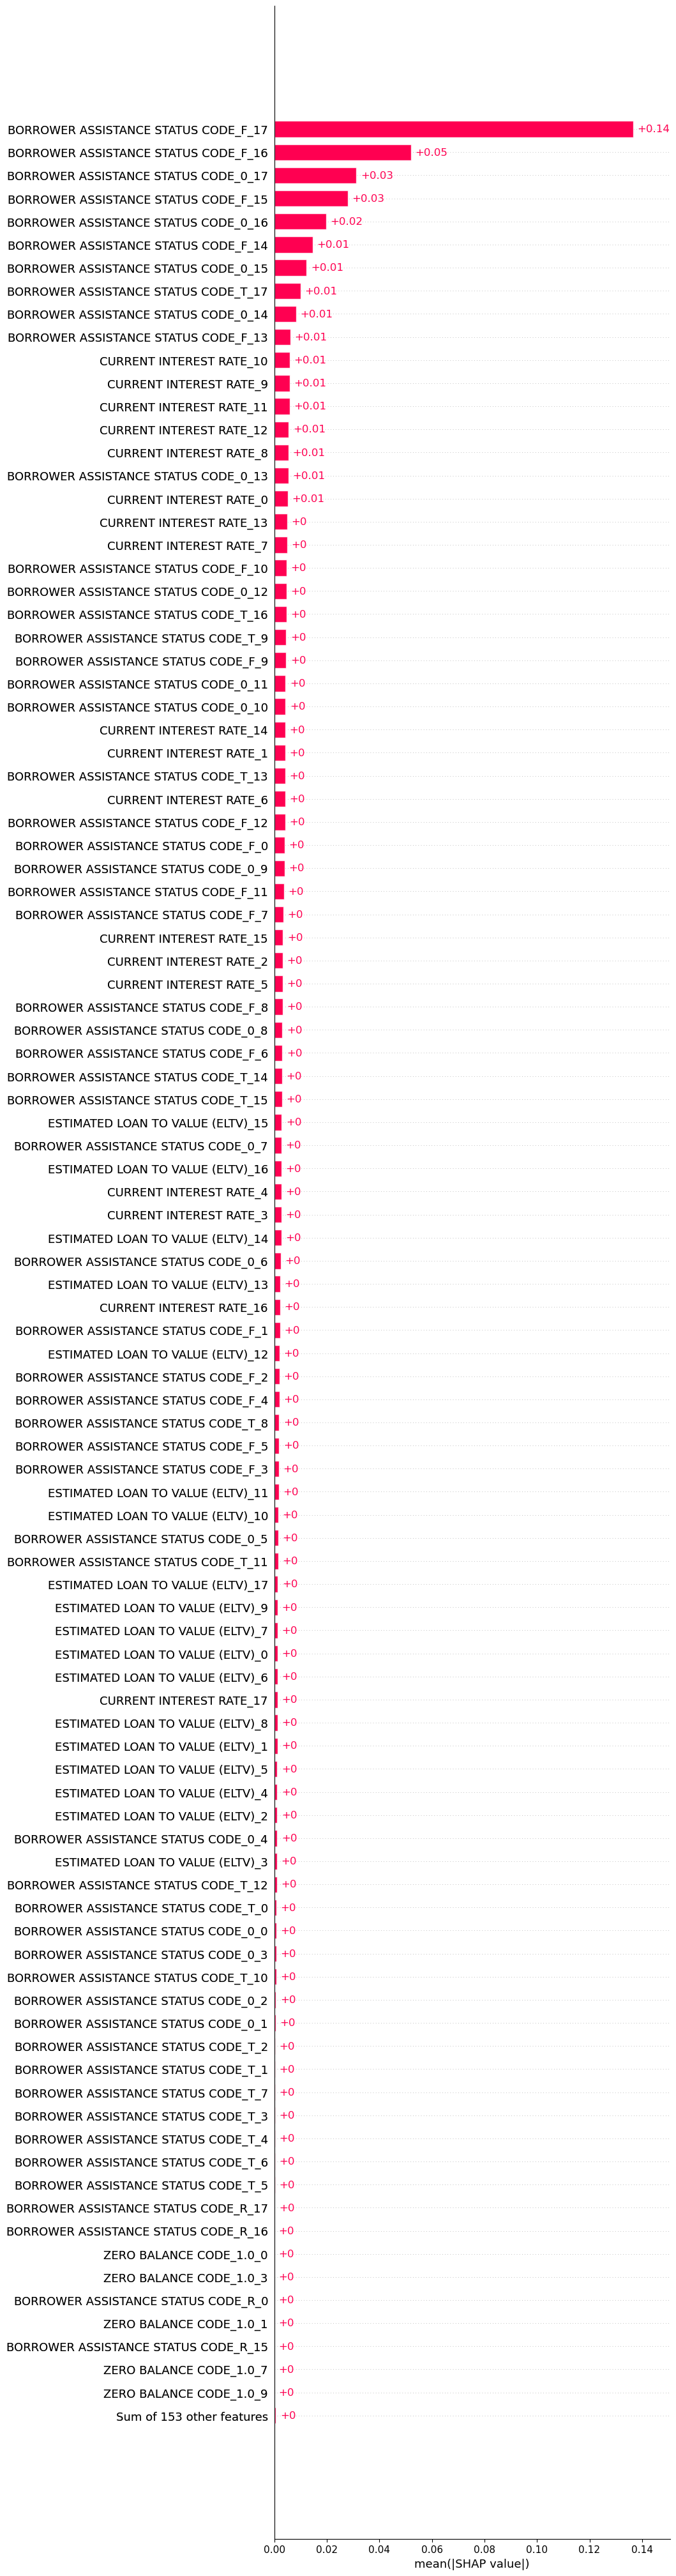

In [14]:
shap.plots.bar(explanation, max_display=100)

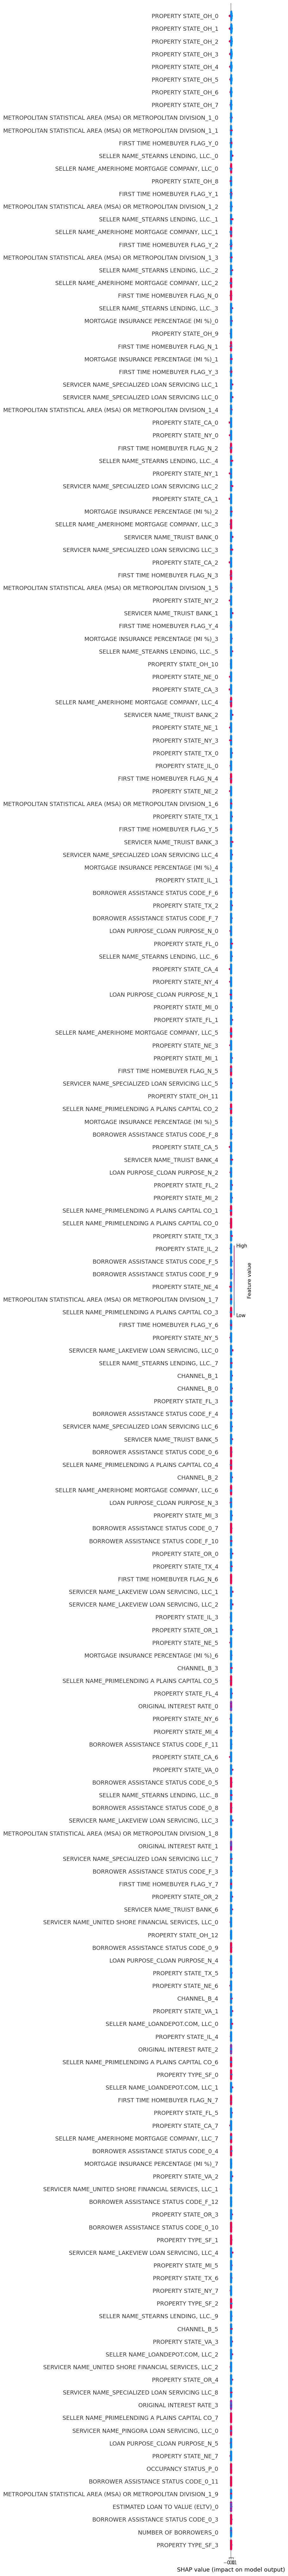

In [10]:
shap.summary_plot(shap_values, testX2D, feature_names=feature_names, max_display=200)

18*11条数据
18 为时间片段数
11 为特征数
分别为： CURRENT INTEREST RATE， ESTIMATED LOAN TO VALUE (ELTV)， INTEREST BEARING UPB-Delta， ZERO BALANCE CODE_0.0， ZERO BALANCE CODE_1.0， ZERO BALANCE CODE_9.0， ZERO BALANCE CODE_96.0， BORROWER ASSISTANCE STATUS CODE_0， BORROWER ASSISTANCE STATUS CODE_F， BORROWER ASSISTANCE STATUS CODE_R， BORROWER ASSISTANCE STATUS CODE_T